# Land Cover Classification

## Imports

In [15]:
import cv2 as cv
import scipy.io as sio
from scipy.stats import multivariate_normal
import numpy as np
from random import seed
from random import randint
from matplotlib import pyplot as plt
from sklearn.covariance import ledoit_wolf as lw
from sklearn.model_selection import train_test_split as split

## Read in the images

In [3]:
fe = cv.imread("fe.bmp")
le = cv.imread("le.bmp")
r = cv.imread("r.bmp")
g = cv.imread("g.bmp")
b = cv.imread("b.bmp")
nir = cv.imread("nir.bmp")

Using the OpenCV2 library, all of the image files are read into the notebook for use later in the project.

## Display the images

(<matplotlib.axes._subplots.AxesSubplot at 0x1d1b8711588>,
 <matplotlib.image.AxesImage at 0x1d1b8776a48>)

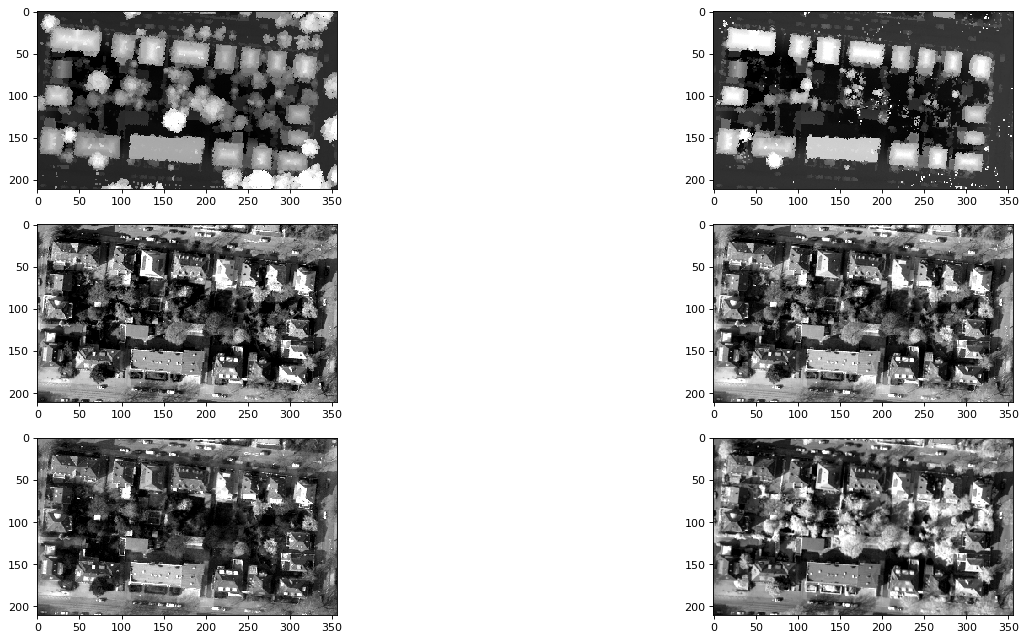

In [4]:
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(321), plt.imshow(fe, cmap = 'gray')
plt.subplot(322), plt.imshow(le, cmap = 'gray')
plt.subplot(323), plt.imshow(r, cmap = 'gray')
plt.subplot(324), plt.imshow(g, cmap = 'gray')
plt.subplot(325), plt.imshow(b, cmap = 'gray')
plt.subplot(326), plt.imshow(nir, cmap = 'gray')

Above are the 6 images for use in theis task. They are all of the same scene, but with differing levels of quality.

## Read in Ground Truth

In [5]:
matLab = sio.loadmat("ground_truth.mat")
ground_truth = matLab['labelled_ground_truth']

Since this is a Python notebook and the data to be used is a MATLAB file, the data must be read in and converted using the "scipy" library.

## Helper Functions

### Generate X and Y Coordinates

In [6]:
def genXY():
    # Get a random integer for X
    X = randint(0, 355)
    # Get a random integer for Y
    Y = randint(0, 210)
    # Return  Y,X since numpy indexes this way.
    return Y,X

The above function generates X and Y coordinate values based on the size of the numpy array. Since the ground_truth has specified dimensions, we can set the upper bounds for the generator accordingly

### Generate a Vector

In [7]:
def genVector(x,y):
    # Declare an empty list
    tmp = []
    # Append the pixel intensity for fe
    tmp.append(fe[x,y,1])
    # Append the pixel intensity for le
    tmp.append(le[x,y,1])
    # Append the pixel intensity for r
    tmp.append(r[x,y,1])
    # Append the pixel intensity for g
    tmp.append(g[x,y,1])
    # Append the pixel intensity for b
    tmp.append(b[x,y,1])
    # Append the pixel intensity for nir
    tmp.append(nir[x,y,1])
    # Return tmp
    return tmp

Based off of the passed (x,y) coordinate, generates a 6x1 vector. This is made by taking the pixel intensity from each of the 6 images loaded earlier.

### Generate Sample of Given Size

In [8]:
def genAllData(setSize):
    # Declare an empty list
    test_samples = []
    test_labels = []
    # Declare and set counters for each class in the ground_truth
    counter1 = 0;
    counter2 = 0;
    counter3 = 0;
    counter4 = 0;
    classBalance = setSize / 4
    # While any counter is not equal to 5
    while (counter1 < classBalance or counter2 < classBalance or counter3 < classBalance or counter4 < classBalance):
        # Generate a set of coordinates
        coords = genXY()
        # Get the class from the ground truth
        val = ground_truth[coords[0],coords[1]]
        # If the class is 1 and we haven't got 5 of that class yet
        if val == 1 and counter1 < classBalance:
            # Generate a vector and append it to training samples
            test_samples.append(genVector(coords[0], coords[1]))
            test_labels.append(1)
            # Increment the counter for this class
            counter1+=1
        # If the class is 2 and we haven't got 5 of that class yet
        elif val == 2 and counter2 < classBalance:
            # Generate a vector and append it to training samples
            test_samples.append(genVector(coords[0], coords[1]))
            test_labels.append(2)
            # Increment the counter for this class
            counter2+=1
        # If the class is 3 and we haven't got 5 of that class yet
        elif val == 3 and counter3 < classBalance:
            # Generate a vector and append it to training samples
            test_samples.append(genVector(coords[0], coords[1]))
            test_labels.append(3)
            # Increment the counter for this class
            counter3+=1
        # If the class is 4 and we haven't got 5 of that class yet
        elif val == 4 and counter4 < classBalance:
            # Generate a vector and append it to training samples
            test_samples.append(genVector(coords[0], coords[1]))
            test_labels.append(4)
            # Increment the counter for this class
            counter4+=1
    # Return the training samples
    return test_samples, test_labels

This function generates the 20 training vectors. Given that there are 4 classes and we want 20 vectors, we can assume that we want 5 instances of each class in the training set. This gives us a even distribution of the classes in the training set.

## Generate the Training Samples

### Get the total number of pixels

In [9]:
total_pixel_count = 0
for i in range(0, len(ground_truth)):
    for j in range(0, len(ground_truth[0])):
        total_pixel_count += 1
print(total_pixel_count)

75116


### Find total number of each class

In [10]:
class_1_count = 0
class_2_count = 0
class_3_count = 0
class_4_count = 0
for i in range(0, len(ground_truth)):
    for j in range(0, len(ground_truth[0])):
        if ground_truth[i][j] == 1:
            class_1_count += 1
        elif ground_truth[i][j] == 2:
            class_2_count += 1
        elif ground_truth[i][j] == 3:
            class_3_count += 1
        else:
            class_4_count += 1
print("Class 1 Count: ",class_1_count)
print("Class 2 Count: ",class_2_count)
print("Class 3 Count: ",class_3_count)
print("Class 4 Count: ",class_4_count)

Class 1 Count:  21573
Class 2 Count:  24144
Class 3 Count:  1105
Class 4 Count:  28294


Since class three has a lot less instances, we will balance the data set first.

### Balancing the data

A simple draw data function. May need to be improved by randomization later.

In [11]:
def drawData(setSize, classNum):
    sample = []
    for i in range(0, len(ground_truth)):
        for j in range(0, len(ground_truth[0])):
            if ground_truth[i][j] == classNum:
                sample.append(genVector(i, j))
            if len(sample) == setSize:
                return sample

In [13]:
class_1_data = drawData(1105, 1)
class_1_data = np.array(class_1_data)
print(len(class_1_data))
class_2_data = drawData(1105, 2)
class_2_data = np.array(class_2_data)
print(len(class_2_data))
class_3_data = drawData(1105, 3)
class_3_data = np.array(class_3_data)
print(len(class_3_data))
class_4_data = drawData(1105, 4)
class_4_data = np.array(class_4_data)
print(len(class_4_data))

1105
1105
1105
1105


Now all classes have the same sample size. 

### Splitting the data into training and test

In [21]:
class_1_data_train, class_1_data_test = split(class_1_data, test_size=0.2)
class_2_data_train, class_2_data_test = split(class_2_data, test_size=0.2)
class_3_data_train, class_3_data_test = split(class_3_data, test_size=0.2)
class_4_data_train, class_4_data_test = split(class_4_data, test_size=0.2)

In [27]:
class_1_data_train = np.array(class_1_data_train)
class_2_data_train = np.array(class_2_data_train)
class_3_data_train = np.array(class_3_data_train)
class_4_data_train = np.array(class_4_data_train)

class_1_data_test = np.array(class_1_data_test)
class_2_data_test = np.array(class_2_data_test)
class_3_data_test = np.array(class_3_data_test)
class_4_data_test = np.array(class_4_data_test)

Data has now been split into a training and test set for each

### Generate the Mean Vectors

In [28]:
mu_1 = class_1_data_train.mean(axis=0)
mu_2 = class_2_data_train.mean(axis=0)
mu_3 = class_3_data_train.mean(axis=0)
mu_4 = class_4_data_train.mean(axis=0)

### Generate the Covariance Matrices

In [29]:
cov_1 = np.cov(class_1_data_train, rowvar=0)
cov_2 = np.cov(class_2_data_train, rowvar=0)
cov_3 = np.cov(class_3_data_train, rowvar=0)
cov_4 = np.cov(class_4_data_train, rowvar=0)

## Gaussian Model Creation

In [30]:
gauss_1 = multivariate_normal.pdf(class_1_data_train, mean=mu_1, cov=cov_1)
gauss_2 = multivariate_normal.pdf(class_2_data_train, mean=mu_2, cov=cov_2)
gauss_3 = multivariate_normal.pdf(class_3_data_train, mean=mu_3, cov=cov_3)
gauss_4 = multivariate_normal.pdf(class_4_data_train, mean=mu_4, cov=cov_4)

(<matplotlib.axes._subplots.AxesSubplot at 0x1d1b8a19fc8>,
 [<matplotlib.lines.Line2D at 0x1d1b8a4d488>])

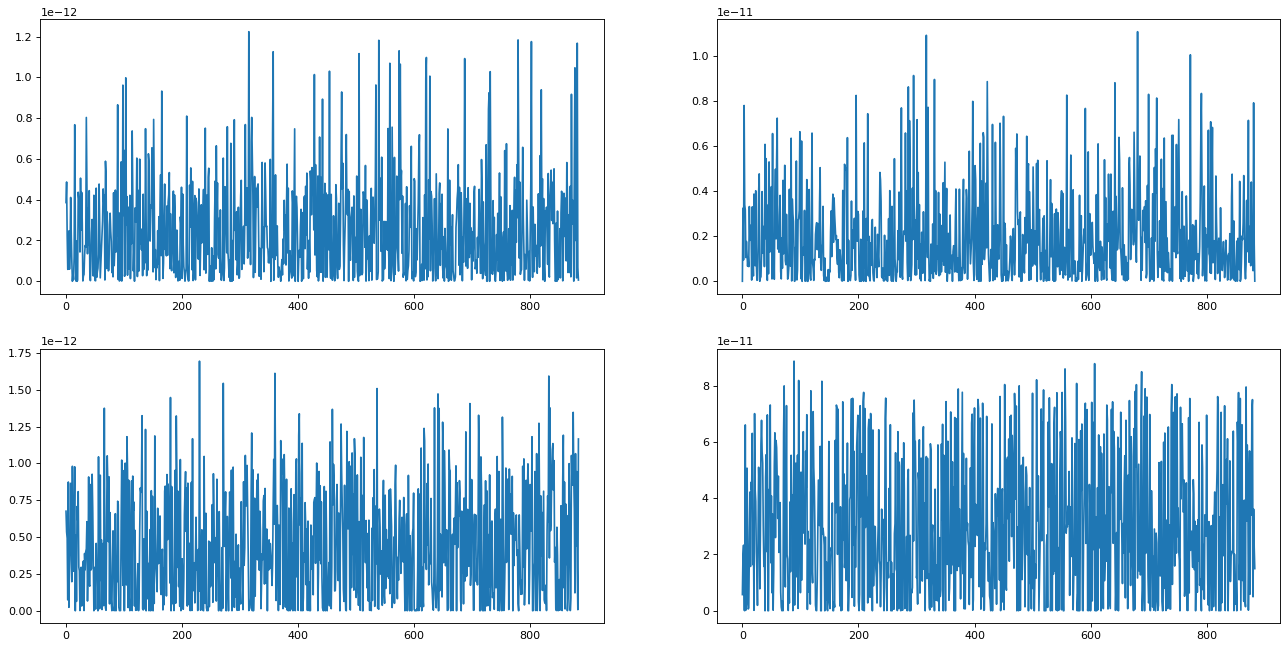

In [31]:
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(221), plt.plot(gauss_1)
plt.subplot(222), plt.plot(gauss_2)
plt.subplot(223), plt.plot(gauss_3)
plt.subplot(224), plt.plot(gauss_4)

## Maximum Likelihood Classification

In [32]:
def determineClassification(classes):
    tmp = 0.0
    classification = -1
    for i in range(0, len(classes)):
        if(classes[i] > tmp):
            tmp = classes[i]
            classification = i+1
    return classification

In [33]:
def classify(pixel):
    classifier = [multivariate_normal.pdf(pixel, mean=mu_1, cov=cov_1),multivariate_normal.pdf(pixel, mean=mu_2, cov=cov_2),multivariate_normal.pdf(pixel, mean=mu_3, cov=cov_3),multivariate_normal.pdf(pixel, mean=mu_4, cov=cov_4)]
    return determineClassification(classifier)

In [34]:
total_samples = [class_1_data_test, class_2_data_test, class_3_data_test, class_4_data_test]
counter = 0
total_counter = 0
for i in range(0, len(total_samples)):
    for j in range(0, len(total_samples[i])):
        classification = classify(total_samples[i][j])
        if classification == i+1:
            counter += 1
        total_counter += 1
accuracy = (counter / total_counter) * 100
print("Accuracy on train set: ",accuracy,"%")

Accuracy on train set:  74.2081447963801 %


## Results and Evaluation